In [12]:
import numpy as np
import matplotlib.pyplot as plt
from planners.basic_prm import BasicPRM
from planners.lazy_prm import LazyPRM
from planners.visibility_prm import VisibilityPRM
from planners.hierarchical_planner import HierarchicalPlanner
from utils.planarRobot import PlanarRobot, KinChainCollisionChecker
from utils.basic_prm_visualize import basic_prm_visualize
from utils.lazy_prm_visualize import lazy_prm_visualize
from utils.visibility_prm_visualize import visibility_prm_visualize
from utils.hierarchical_visualize import visualize_hierarchical_planning
from environment import get_all_scenes
from matplotlib.animation import FuncAnimation
import time
import pandas as pd
from shapely.geometry import LineString
import networkx as nx

In [10]:
# --- Konfiguration ---
DOF = 2
link_lengths = [1.5] * DOF
robot = PlanarRobot(n_joints=DOF, link_lengths=link_lengths)

# Benchmark-Szenen laden
scenes = get_all_scenes()
benchmarks = [(name, scene, limits, start, goal) for name, (scene, limits, (start, goal)) in scenes]

# Planner Konfigurationen
def get_configs():
    return {
        "Basic": {"radius": 2.0, "numNodes": 250},
        "Lazy": {"initialRoadmapSize": 250, "updateRoadmapSize": 50, "kNearest": 10, "maxIterations": 25},
        "Vis": {"ntry": 40},
        "HierBasic": {"ntry": 40},
        "HierLazy": {"ntry": 40}
    }

planner_setups = {
    "Basic": lambda cc, lim: BasicPRM(cc, lim),
    "Lazy": lambda cc, lim: LazyPRM(cc, lim),
    "Vis": lambda cc, lim: VisibilityPRM(cc, lim),
    "HierBasic": lambda cc, lim: HierarchicalPlanner(cc.scene, lim, VisibilityPRM, BasicPRM, get_configs()["HierBasic"], get_configs()["Basic"]),
    "HierLazy": lambda cc, lim: HierarchicalPlanner(cc.scene, lim, VisibilityPRM, LazyPRM, get_configs()["HierLazy"], get_configs()["Lazy"]),
}



🔍 Szene: U-Shape
🚀 Starte Planner: Basic


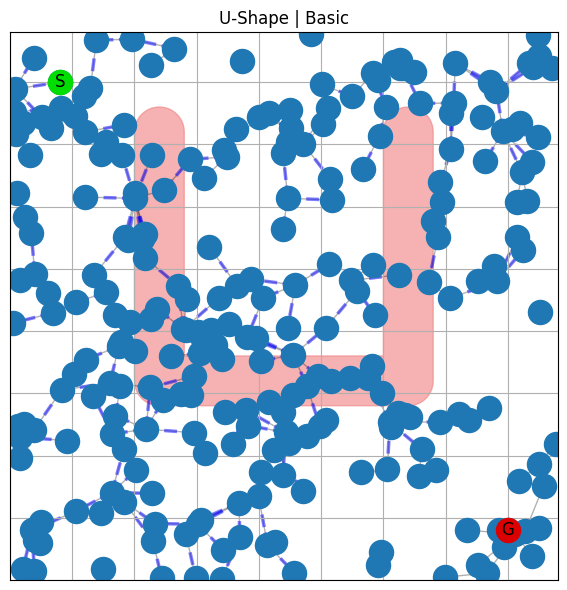

🚀 Starte Planner: Lazy


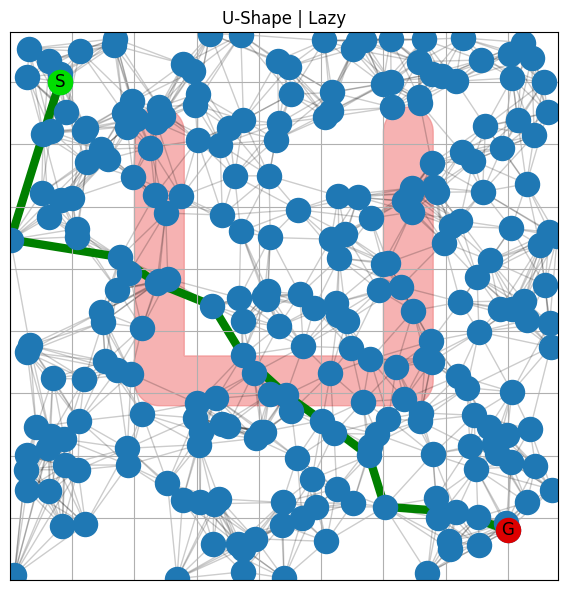

🚀 Starte Planner: Vis
❌ Fehler bei Vis: 'KinChainCollisionChecker' object has no attribute 'values'
🚀 Starte Planner: HierBasic
❌ Fehler bei HierBasic: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given
🚀 Starte Planner: HierLazy
❌ Fehler bei HierLazy: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given

🔍 Szene: L-Shape
🚀 Starte Planner: Basic


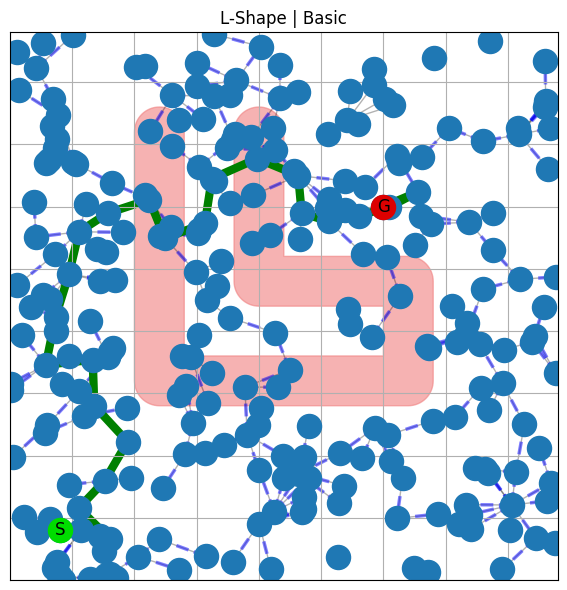

🚀 Starte Planner: Lazy


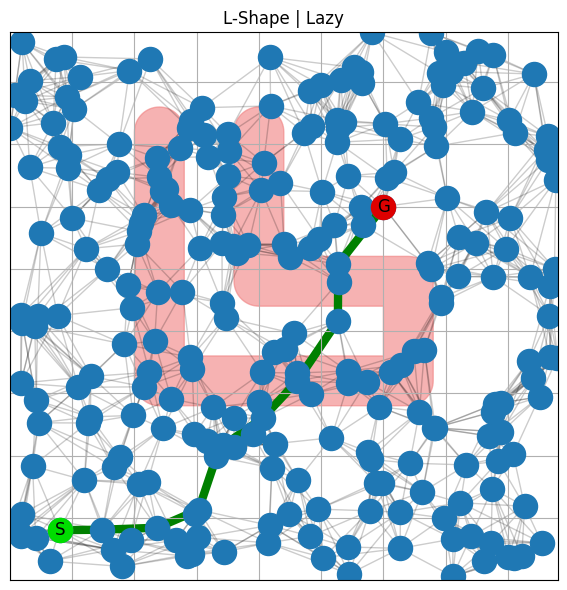

🚀 Starte Planner: Vis
❌ Fehler bei Vis: 'KinChainCollisionChecker' object has no attribute 'values'
🚀 Starte Planner: HierBasic
❌ Fehler bei HierBasic: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given
🚀 Starte Planner: HierLazy
❌ Fehler bei HierLazy: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given

🔍 Szene: Cross-Shape
🚀 Starte Planner: Basic


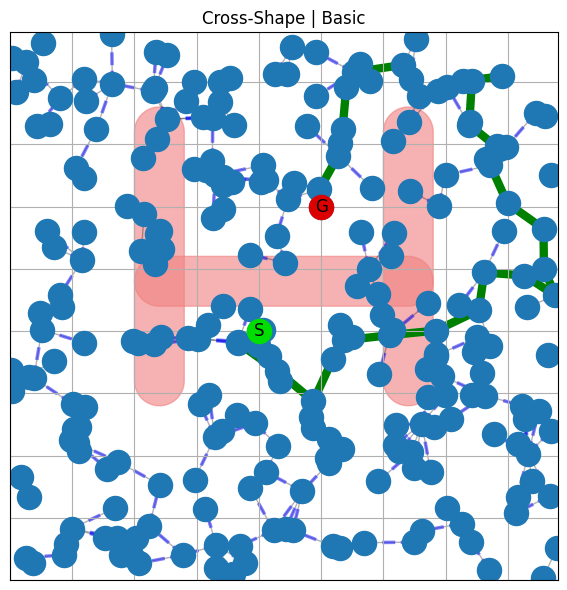

🚀 Starte Planner: Lazy


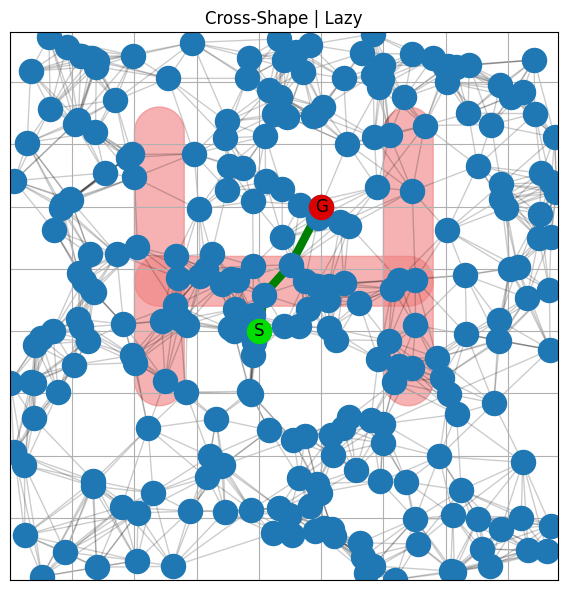

🚀 Starte Planner: Vis
❌ Fehler bei Vis: 'KinChainCollisionChecker' object has no attribute 'values'
🚀 Starte Planner: HierBasic
❌ Fehler bei HierBasic: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given
🚀 Starte Planner: HierLazy
❌ Fehler bei HierLazy: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given

🔍 Szene: Corridor
🚀 Starte Planner: Basic


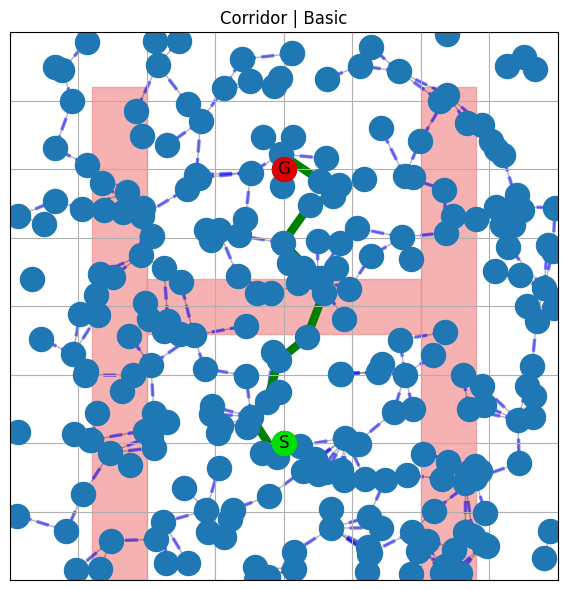

🚀 Starte Planner: Lazy


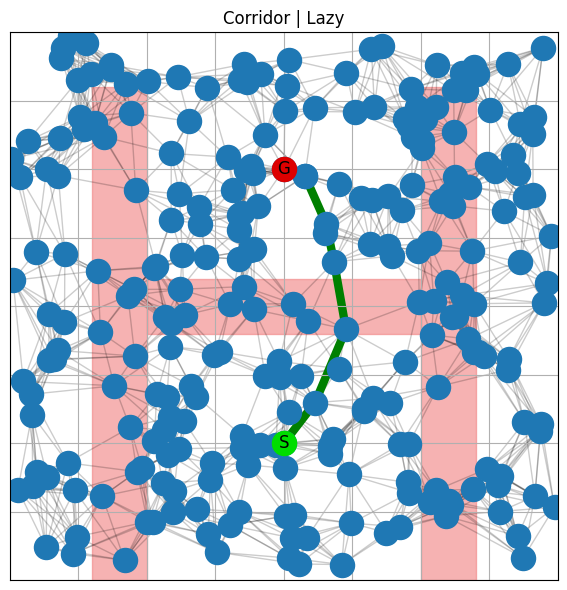

🚀 Starte Planner: Vis
❌ Fehler bei Vis: 'KinChainCollisionChecker' object has no attribute 'values'
🚀 Starte Planner: HierBasic
❌ Fehler bei HierBasic: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given
🚀 Starte Planner: HierLazy
❌ Fehler bei HierLazy: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given

🔍 Szene: Complex Shape
🚀 Starte Planner: Basic


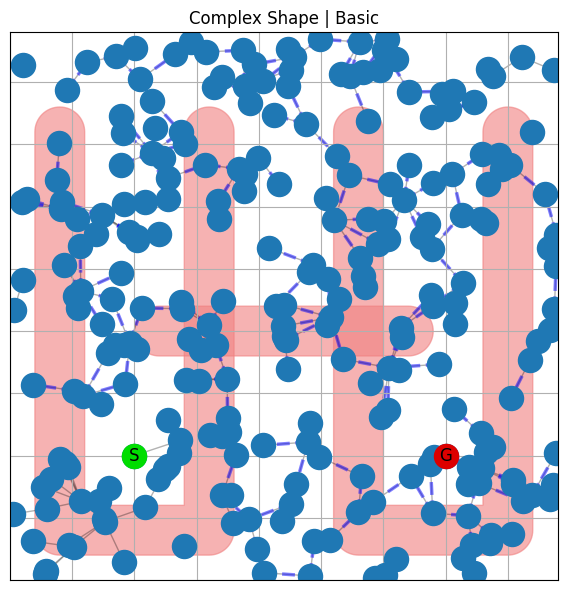

🚀 Starte Planner: Lazy


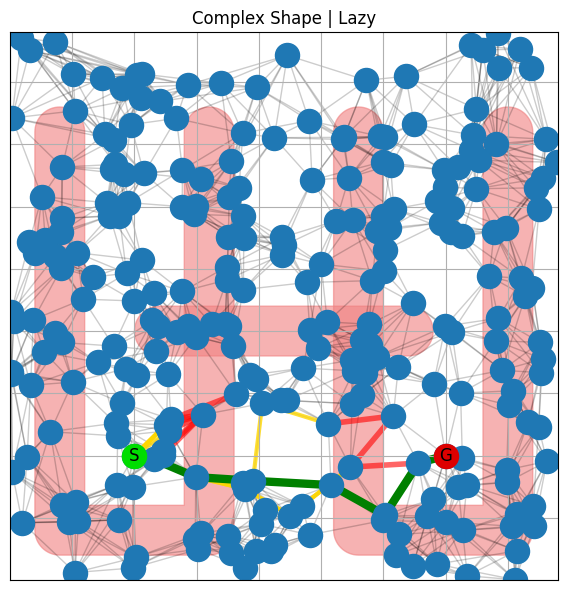

🚀 Starte Planner: Vis
❌ Fehler bei Vis: 'KinChainCollisionChecker' object has no attribute 'values'
🚀 Starte Planner: HierBasic
❌ Fehler bei HierBasic: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given
🚀 Starte Planner: HierLazy
❌ Fehler bei HierLazy: HierarchicalPlanner.plan_path() takes 3 positional arguments but 4 were given

🔍 Szene: Multiple Obstacles
🚀 Starte Planner: Basic


NetworkXPointlessConcept: Connectivity is undefined for the null graph.

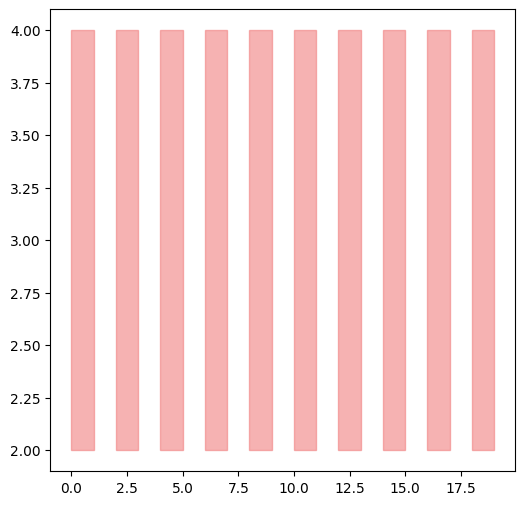

In [13]:
# Ergebnisse
results = []

# Benchmarks ausführen
for name, scene, limits, start, goal in benchmarks:
    print(f"\n🔍 Szene: {name}")

    for planner_name, factory in planner_setups.items():
        print(f"🚀 Starte Planner: {planner_name}")
        config = get_configs()[planner_name]

        # Kollisionstester
        cc = KinChainCollisionChecker(robot, scene, fk_resolution=0.1)

        # Instanziierung
        planner = factory(cc, limits)

        # Prüfung: Gelenkraum oder 2D Raum
        is_joint_space = len(limits[0]) > 2 or isinstance(cc, KinChainCollisionChecker)
        if is_joint_space:
            planner.is_joint_space = True

        # Planung mit Zeitmessung
        t0 = time.time()
        try:
            path = planner.plan_path([start], [goal], config)
            t1 = time.time()
        except Exception as e:
            print(f"❌ Fehler bei {planner_name}: {e}")
            continue

        coords = planner.get_path_coordinates(path) if path else []

        result = {
            "planner": planner_name,
            "scene": name,
            "hasPath": bool(path),
            "length": len(path) if path else 0,
            "time": t1 - t0,
            "nodes": len(planner.graph.nodes) if hasattr(planner, "graph") else 0,
            "edges": len(planner.graph.edges) if hasattr(planner, "graph") else 0
        }
        results.append(result)

        # Optional Visualisierung pro Szene
        fig, ax = plt.subplots(figsize=(6, 6))
        if planner_name.startswith("Basic"):
            basic_prm_visualize(planner, path, ax)
        elif planner_name.startswith("Lazy"):
            lazy_prm_visualize(planner, path, ax)
        elif planner_name.startswith("Vis"):
            visibility_prm_visualize(planner, path, ax)
        elif planner_name.startswith("Hier"):
            visualize_hierarchical_planning(planner, path, ax)
        plt.title(f"{name} | {planner_name}")
        plt.tight_layout()
        plt.show()

# Ergebnisse darstellen
result_df = pd.DataFrame(results)

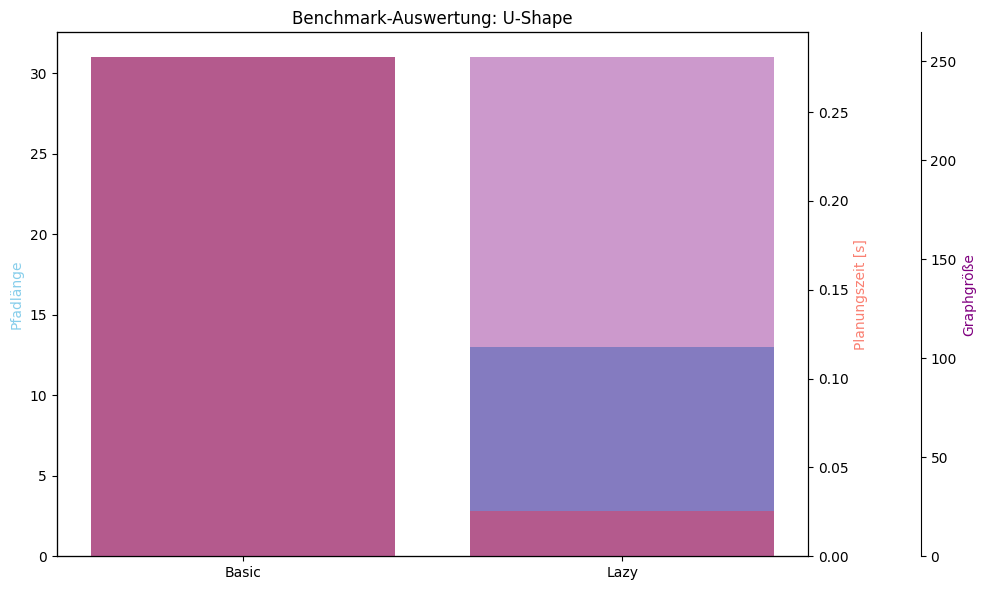

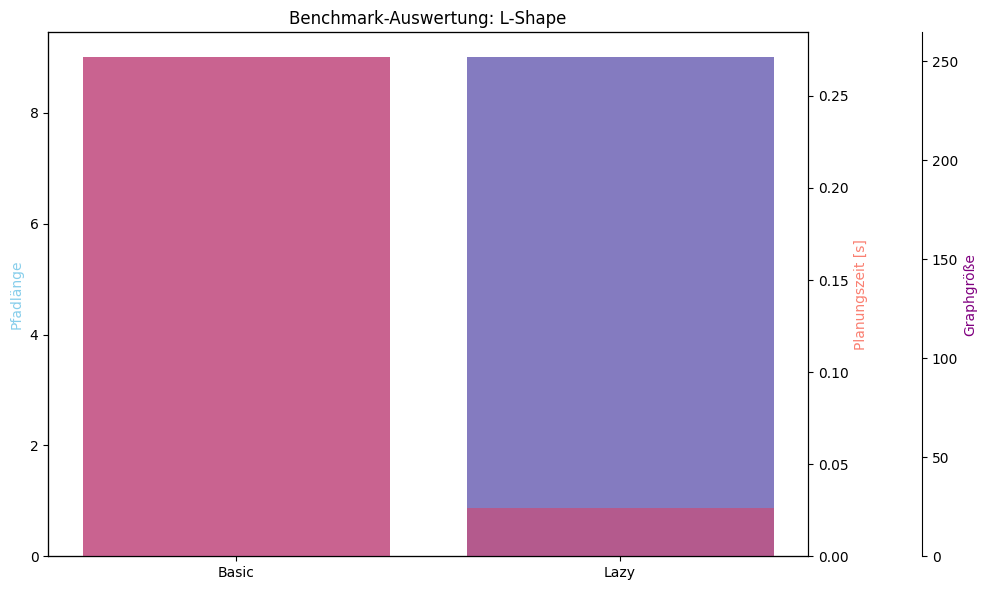

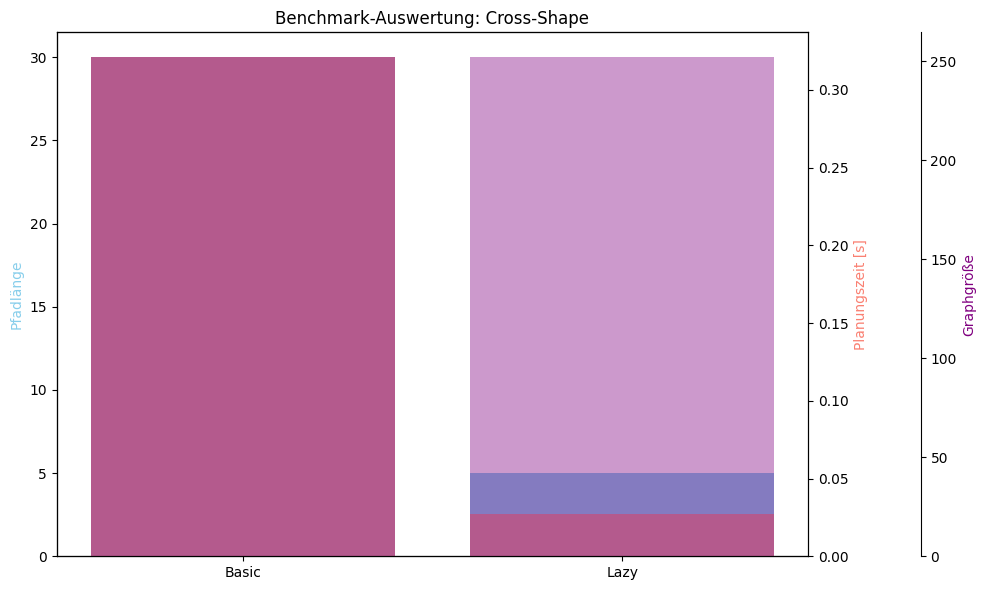

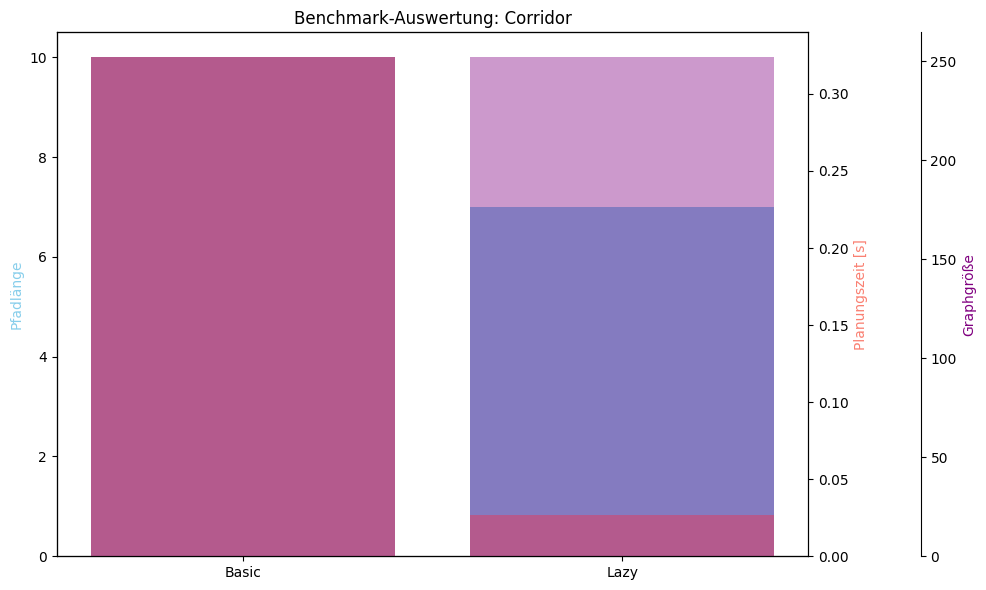

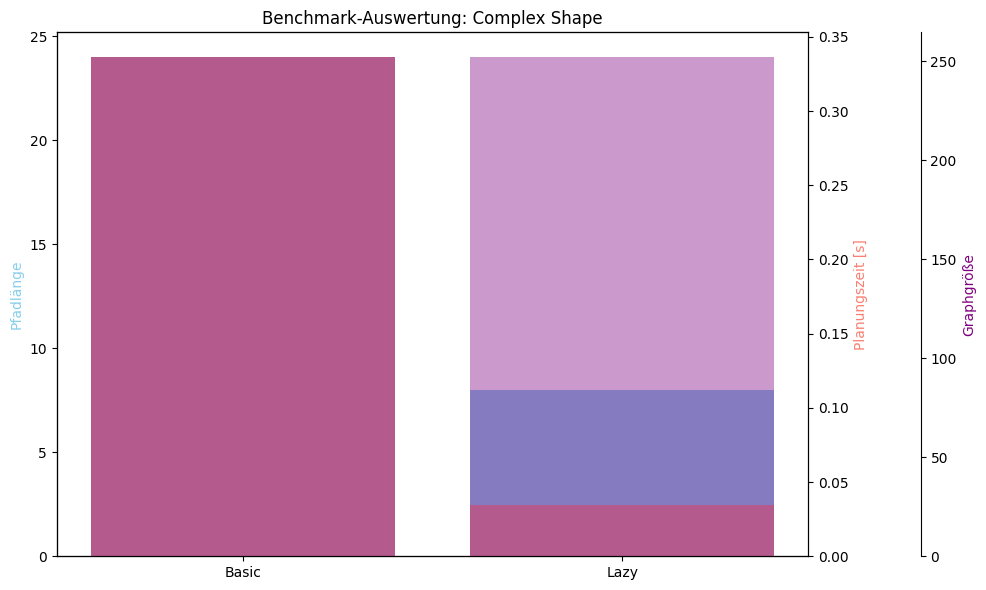

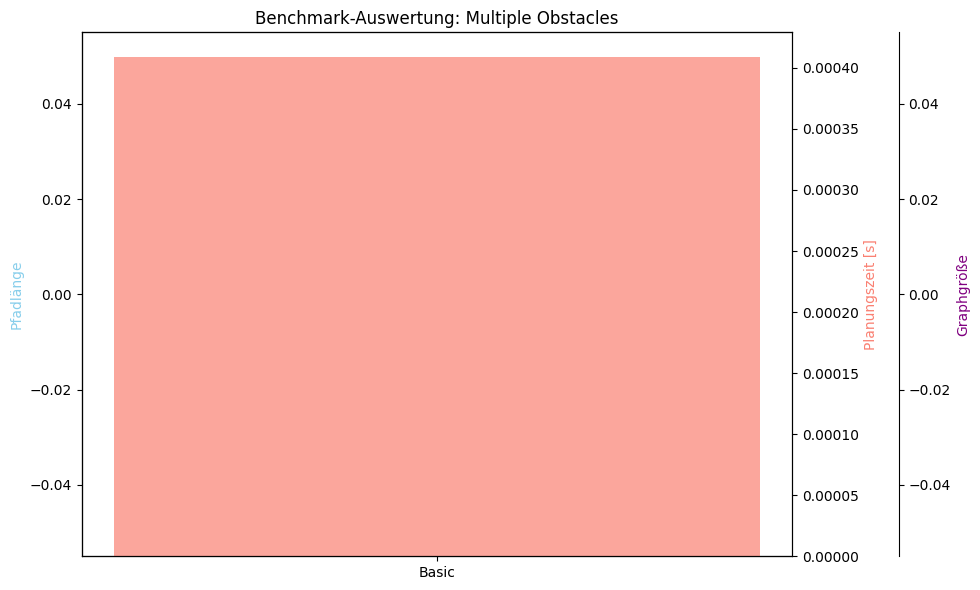

In [8]:
# Ergebnisse darstellen
result_df = pd.DataFrame(results)

# Zusammenfassung
for scene in result_df["scene"].unique():
    df = result_df[result_df["scene"] == scene]

    fig, ax = plt.subplots(figsize=(10, 6))
    bar1 = ax.bar(df["planner"], df["length"], label="Path Length", color="skyblue")
    ax.set_ylabel("Pfadlänge", color="skyblue")

    ax2 = ax.twinx()
    bar2 = ax2.bar(df["planner"], df["time"], label="Zeit", color="salmon", alpha=0.7)
    ax2.set_ylabel("Planungszeit [s]", color="salmon")

    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.15))
    bar3 = ax3.bar(df["planner"], df["nodes"], label="Knoten", color="purple", alpha=0.4)
    ax3.set_ylabel("Graphgröße", color="purple")

    plt.title(f"Benchmark-Auswertung: {scene}")
    plt.tight_layout()
    plt.show()


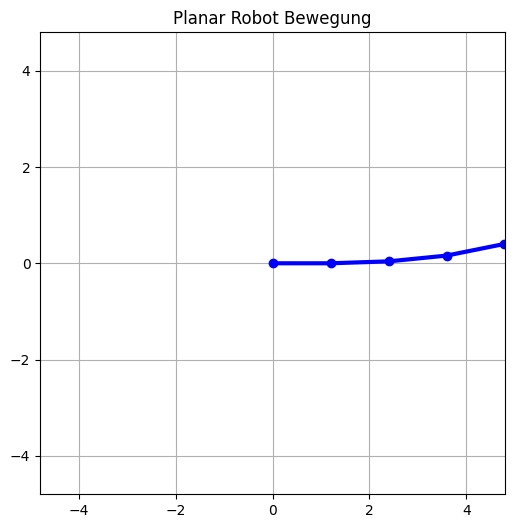

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from planners.basic_prm import BasicPRM
from utils.planarRobot import PlanarRobot, KinChainCollisionChecker
from environment import get_all_scenes
from matplotlib.animation import FuncAnimation


In [7]:
# --- Konfiguration für 2 DOF Beispiel ---
DOF = 2
link_lengths = [1.5] * DOF
robot = PlanarRobot(n_joints=DOF, link_lengths=link_lengths)

# Beispielszene laden
scenes = get_all_scenes()
scene_name, (scene, limits, (start_pos, goal_pos)) = scenes[0]  # erste Szene

# Kollisionstestobjekt erzeugen
collision_checker = KinChainCollisionChecker(robot, scene, fk_resolution=0.05)

In [15]:
# PRM-Planer instanziieren
planner = BasicPRM(collision_checker, limits=[[-np.pi]*DOF, [np.pi]*DOF])

# Start- und Zielkonfigurationen (in Joint-Space)
start = [[0.0, 0.1]]
goal = [[np.pi/2, np.pi/2.5]]

config = {"numNodes": 400, "radius": 1.5}

# Planung durchführen
path = planner.plan_path(start, goal, config)
print("Pfad gefunden!" if path else "Kein Pfad gefunden.")
print(f"Anzahl der Knoten im PRM: {planner.graph.number_of_nodes()}")
print(f"Gefundene Pfadlänge: {len(path)}" if path else "Kein Pfad gefunden.")
print(f"Knoten der Lösung: {path}" if path else "Keine Knoten in der Lösung.")


Pfad gefunden!
Anzahl der Knoten im PRM: 402
Gefundene Pfadlänge: 12
Knoten der Lösung: ['start', 3, 11, 14, 10, 23, 40, 5, 6, 39, 20, 'goal']


In [16]:
# Visualisierung

def animate_path(robot, path_configs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Roboterarbeitsraum vorbereiten
    ax1.set_xlim(-sum(robot.link_lengths), sum(robot.link_lengths))
    ax1.set_ylim(-sum(robot.link_lengths), sum(robot.link_lengths))
    ax1.set_aspect("equal")
    ax1.grid(True)
    ax1.set_title(f"Planar Roboter Bewegung ({DOF} DOF)")

    # Hindernisse darstellen
    for obs in scene.values():
        if hasattr(obs, "exterior"):
            xs, ys = obs.exterior.xy
            ax1.fill(xs, ys, color='red', alpha=0.4)

    line1, = ax1.plot([], [], 'o-', lw=3, color='green')

    # Konfigurationsraum vorbereiten
    ax2.set_xlim(-np.pi, np.pi)
    ax2.set_ylim(-np.pi, np.pi)
    ax2.set_aspect("auto")
    ax2.grid(True)
    ax2.set_title("Konfigurationsraum")
    line2, = ax2.plot([], [], 'o-', color='blue')

    def update(i):
        pos = robot.forward_kinematics(path_configs[i])
        xs, ys = zip(*pos)
        line1.set_data(xs, ys)

        # Zeige aktuelle Konfiguration (Joint-Achsen) im C-Space
        q = path_configs[i]
        line2.set_data([q[0]], [q[1]])
        return line1, line2

    ani = FuncAnimation(fig, update, frames=len(path_configs), interval=100, blit=True)
    plt.tight_layout()
    plt.show()

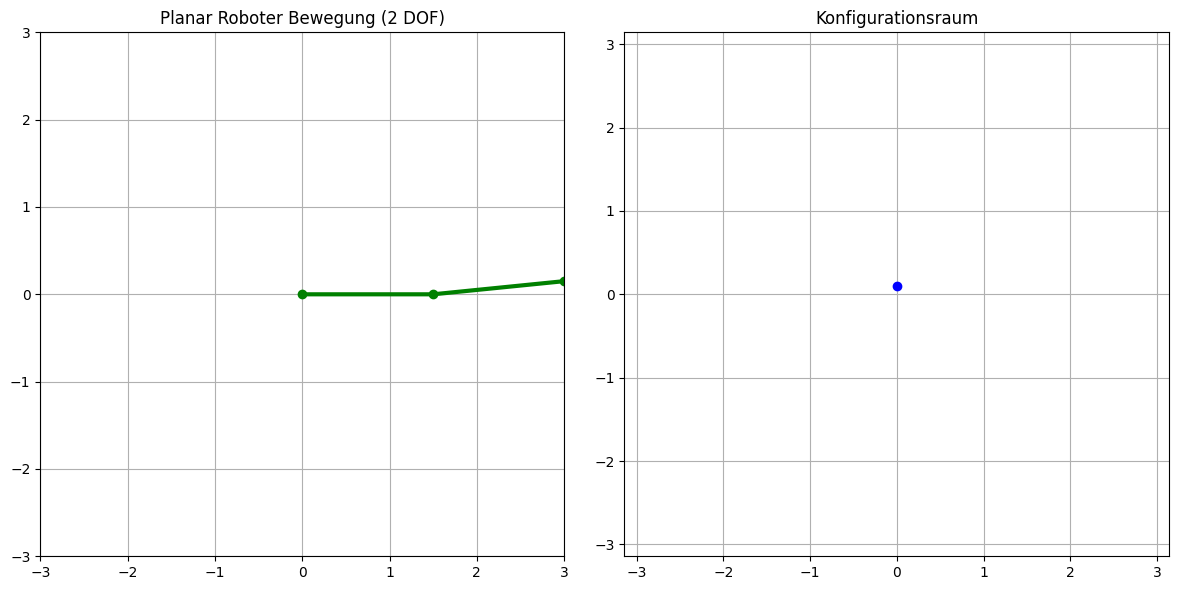

In [17]:
if path:
    configs = planner.get_path_coordinates(path)
    animate_path(robot, configs)
